# Random Forest Classification via cross-validation

classification task: SL (1) or not SL (0)

*StratifiedKFold* is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

*StratifiedGroupKFold* is used to generate the train and test sets for model 2 and model 3

In [1]:
# import modules
import os
import pandas as pd
import numpy as np
import random

# import scikit-learn modules
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score, average_precision_score, precision_recall_curve, auc, roc_curve

# import visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

import time

In [2]:
# save path
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DRIVE_PATH'] + '/' + '/'.join(folders) + '/' + fname)

# load data
file_path = get_data_path(['SL PRED', 'input', 'gemini'], 'ito_pairs_annotated.csv')
old_classifier_path = get_data_path(['SL PRED', 'input'], 're_bprediction.csv')

# output
#figure_path_model1 = get_data_path(['SL PRED', 'Fig 3'], 'model1.png')
#figure_path_model2 = get_data_path(['SL PRED', 'Fig 3'], 'model2.png')
#figure_path_model3 = get_data_path(['SL PRED', 'Fig 3'], 'model3.png')
#figure_path_model4 = get_data_path(['SL PRED', 'Fig 3'], 'model4.png')


In [3]:
training_df = pd.read_csv(file_path)
training_df.head()

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,smallest_GO_CC_gene_effect,min_GO_CC_gene_z_effect,max_GO_CC_gene_z_effect,smallest_GO_CC_gene_z_effect,prediction_score,GEMINI,LFC,SL_1,SL_08,SL_06
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,-0.104289,-0.021442,0.029952,0.003538,0.012559,0.118768,0.088856,False,False,False
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,-0.103074,-0.032004,0.021698,-0.010239,0.012559,0.132501,0.201704,False,False,False
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,-0.099791,-0.018027,0.022543,-0.000695,0.012559,0.024593,0.069772,False,False,False
3,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000681,A549_LUNG,0.977988,0.379455,False,...,-0.095668,-0.012634,0.034220,0.009562,0.012559,-0.241323,0.379455,False,False,False
4,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000756,GI1_CENTRAL_NERVOUS_SYSTEM,0.999586,-0.077118,False,...,-0.097826,-0.013141,0.044570,0.018164,0.012559,0.299715,-0.077118,False,False,False


In [4]:
general_classifier_training_df = pd.read_csv(old_classifier_path)
general_classifier_training_df.head()

,prediction_rank,prediction_percentile,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,prediction_score,...,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,shared_ppi_mean_essentiality,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,1,0.1,SMARCA2_SMARCA4,SMARCA2,SMARCA4,6595,6597,ENSG00000080503,ENSG00000127616,0.430886,...,True,0.387262,0.333333,True,302,114.614142,0.225382,0.627875,18.609973,34.302868
1,2,0.1,EXOC6_EXOC6B,EXOC6,EXOC6B,54536,23233,ENSG00000138190,ENSG00000144036,0.410447,...,True,0.486857,0.250000,True,53,29.782706,0.285886,0.069456,6.390812,11.168367
2,3,0.1,STAG1_STAG2,STAG1,STAG2,10274,10735,ENSG00000118007,ENSG00000101972,0.405952,...,True,0.897254,0.000000,False,74,39.412527,0.329993,0.854086,13.103716,22.097616
3,4,0.1,RPL3_RPL3L,RPL3,RPL3L,6122,6123,ENSG00000100316,ENSG00000140986,0.402074,...,True,0.853090,0.000000,False,269,55.904504,0.897190,-0.120226,16.459348,1418.958855
4,5,0.1,CNOT7_CNOT8,CNOT7,CNOT8,29883,9337,ENSG00000198791,ENSG00000155508,0.399963,...,True,0.369246,0.000000,False,82,56.161358,0.154692,0.482402,14.829783,41.019617


In [5]:
late_features_df = general_classifier_training_df[['sorted_gene_pair', 'A1_entrez', 'A2_entrez', 'closest', 'WGD', 'family_size', 'cds_length_ratio', 'shared_domains', 'has_pombe_ortholog',
                                            'has_essential_pombe_ortholog', 'has_cerevisiae_ortholog', 'has_essential_cerevisiae_ortholog', 'conservation_score', 'mean_age', 
                                            'either_in_complex', 'mean_complex_essentiality', 'colocalisation', 'interact', 'n_total_ppi', 'fet_ppi_overlap','gtex_spearman_corr', 
                                            'gtex_min_mean_expr', 'gtex_max_mean_expr', 'min_sequence_identity', 'shared_ppi_mean_essentiality']]
late_features_df = late_features_df.rename(columns={'sorted_gene_pair':'genepair'})

In [6]:
integrated_training_df = pd.merge(
    training_df, late_features_df, 
    left_on=['genepair', 'A1_entrez', 'A2_entrez'], 
    right_on=['genepair', 'A1_entrez', 'A2_entrez'], 
    how='left')

bool_columns = ['closest', 'WGD', 'has_pombe_ortholog', 'has_cerevisiae_ortholog', 'has_essential_cerevisiae_ortholog', 'either_in_complex', 'interact']

integrated_training_df[bool_columns] = integrated_training_df[bool_columns].astype(bool)

integrated_training_df[:3]

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,min_sequence_identity,shared_ppi_mean_essentiality
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.340483,0.0
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.340483,0.0
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.340483,0.0


In [7]:
# Feature set for early classifier

feature_columns_1 = ['rMaxExp_A1A2', 'rMinExp_A1A2',
                     'max_ranked_A1A2', 'min_ranked_A1A2',
                     'max_cn', 'min_cn', 'Protein_Altering', 'Damaging', 
                     'max_seq_id', 'min_seq_id',
                     'prediction_score', 
                     'ranked_Essentiality_weighted_PPI', 'Expression_weighted_PPI',
                     'smallest_GO_ranked_ess', 'smallest_GO_CC_ranked_ess',
                     'smallest_gene_expression', 'smallest_GO_CC_expression'
                     ]

target_column = 'SL_08'

print('num of features:', len(feature_columns_1))

num of features: 17


In [8]:
# Feature set for late classifier

feature_columns_2 = feature_columns_1 + ['closest', 'WGD', 'family_size',
                                         'cds_length_ratio', 'shared_domains', 'has_pombe_ortholog',
                                         'has_essential_pombe_ortholog', 'has_cerevisiae_ortholog', 'has_essential_cerevisiae_ortholog', 
                                         'conservation_score', 'mean_age', 'either_in_complex', 'mean_complex_essentiality', 'colocalisation',
                                         'interact', 'n_total_ppi', 'fet_ppi_overlap',
                                         'gtex_spearman_corr', 'gtex_min_mean_expr', 'gtex_max_mean_expr']
feature_columns_2.remove('prediction_score')
print('num of features:', len(feature_columns_2))

num of features: 36


In [9]:
#remove NA values before training the model
integrated_training_df_clean = integrated_training_df.dropna(axis=0, how='any', subset=feature_columns_2 + [target_column]).reset_index(drop=True) 

#summary of the training dataset after removing NA values
print('Num SL:', integrated_training_df_clean[integrated_training_df_clean[target_column] == True].shape[0], '/', integrated_training_df_clean.shape[0])
print('Num non-SL:', integrated_training_df_clean[integrated_training_df_clean[target_column] == False].shape[0], '/', integrated_training_df_clean.shape[0])
print(f'Number of unique gene pairs: {integrated_training_df_clean.genepair.nunique()}')
print(f'Number of unique cell lines: {integrated_training_df_clean.cell_line.nunique()}')
integrated_training_df_clean[:3]

Num SL: 354 / 40829
Num non-SL: 40475 / 40829
Number of unique gene pairs: 4126
Number of unique cell lines: 10


,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,min_sequence_identity,shared_ppi_mean_essentiality
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.340483,0.0
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.340483,0.0
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.340483,0.0


In [10]:
filtered_df_clean = integrated_training_df_clean.loc[~((integrated_training_df_clean['SL_08'] == True) & (integrated_training_df_clean['LFC'] > -0.8))]
assert integrated_training_df_clean.shape[0] == filtered_df_clean.shape[0]

## Model I
#### Random Selection

In [11]:
def model_early_cross_validation(classifier, data, target, splits, verbose=True):
    tprs = []  # To store TPR values for each fold
    fprs = []  # To store FPR values for each fold
    aucs = []  # To store AUC for each fold
    mean_fpr = np.linspace(0, 1, 100)
    pred_aucs = []
    seq_aucs = []
    gene_expr_aucs = []
    gene_ess_aucs = []
    
    y_real = []
    y_proba = []
    aps = []
    pred_aps = []
    seq_aps = []
    gene_expr_aps = []
    gene_ess_aps = []
    
    total_splits = len(splits)
    start_time = time.time()

    for fold_num, (train, test) in enumerate(splits, start=1):
        print(f"Fold {fold_num}: Train size = {len(train)}, Test size = {len(test)}")
        
        if len(test) == 0:  # Check if the test set is empty
            continue

        # Fit the classifier and predict probabilities
        ypred = classifier.fit(data.iloc[train], target.iloc[train]).predict_proba(data.iloc[test])

        if np.unique(target.iloc[test]).size < 2:  # Check if there are positive and negative samples
            print(f"Skipping fold {fold_num} due to insufficient positive/negative samples.")
            continue

        # Compute ROC curve and store TPR/FPR
        fpr, tpr, _ = roc_curve(target.iloc[test], ypred[:, 1])
        tprs.append(tpr)
        fprs.append(fpr)

        # Compute AUC and store
        auc_value = roc_auc_score(target.iloc[test], ypred[:, 1])
        aucs.append(auc_value)

        pred_aucs.append(roc_auc_score(target.iloc[test], data.iloc[test]['prediction_score'].values))
        seq_aucs.append(roc_auc_score(target.iloc[test], data.iloc[test]['max_seq_id'].values))
        gene_expr_aucs.append(roc_auc_score(target.iloc[test], data.iloc[test]['rMinExp_A1A2'].values))
        gene_ess_aucs.append(1 - (roc_auc_score(target.iloc[test], data.iloc[test]['min_ranked_A1A2'].values)))
        
        aps.append(average_precision_score(target.iloc[test], ypred[:, 1]))
        pred_aps.append(average_precision_score(target.iloc[test], data.iloc[test]['prediction_score'].values))
        seq_aps.append(average_precision_score(target.iloc[test], data.iloc[test]['max_seq_id'].values))
        gene_expr_aps.append(average_precision_score(target.iloc[test], data.iloc[test]['rMinExp_A1A2'].values))
        gene_ess_aps.append(average_precision_score(target.iloc[test], data.iloc[test]['min_ranked_A1A2'].values))

        y_real.append(target.iloc[test].values)
        y_proba.append(ypred[:, 1])
        
        # Print progress after each fold
        if verbose:
            elapsed_time = time.time() - start_time
            print(f"Fold {fold_num}/{total_splits} complete: ROC AUC = {auc_value:.4f}, "
                  f"Elapsed time = {elapsed_time:.2f} seconds")
    
    # After all folds, check if we have enough valid data to compute mean ROC
    if len(tprs) > 0:
        mean_tpr = np.mean([np.interp(mean_fpr, fprs[i], tprs[i]) for i in range(len(tprs))], axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
    else:
        mean_tpr, mean_auc, std_auc = np.array([]), np.nan, np.nan  # Handle empty case
    
    # Concatenate all the arrays into 1 array for precision-recall curve
    if len(y_real) > 0 and len(y_proba) > 0:
        y_real = np.concatenate(y_real)
        y_proba = np.concatenate(y_proba)
        precision, recall, _ = precision_recall_curve(y_real, y_proba)
    else:
        precision, recall = np.array([]), np.array([])  # Handle empty case
    
    if verbose and not np.isnan(mean_auc):
        print(f"Cross-validation complete: Mean ROC AUC = {mean_auc:.4f}, Std ROC AUC = {std_auc:.4f}")

    # Return the results as a dictionary
    return {
        'tprs': tprs, 'fprs': fprs, 'aucs': aucs,
        'mean_tpr': mean_tpr, 'mean_fpr': mean_fpr, 'mean_auc': mean_auc, 'std_auc': std_auc,
        'seq_auc': np.mean(seq_aucs) if len(seq_aucs) > 0 else np.nan, 
        'seq_std_auc': np.std(seq_aucs) if len(seq_aucs) > 0 else np.nan,
        'pred_auc': np.mean(pred_aucs) if len(pred_aucs) > 0 else np.nan, 
        'pred_std_auc': np.std(pred_aucs) if len(pred_aucs) > 0 else np.nan,
        'gene_expr_auc': np.mean(gene_expr_aucs) if len(gene_expr_aucs) > 0 else np.nan, 
        'gene_expr_std_auc': np.std(gene_expr_aucs) if len(gene_expr_aucs) > 0 else np.nan,
        'gene_ess_auc': np.mean(gene_ess_aucs) if len(gene_ess_aucs) > 0 else np.nan, 
        'gene_ess_std_auc': np.std(gene_ess_aucs) if len(gene_ess_aucs) > 0 else np.nan,
        'precision': precision, 'recall': recall, 'aps': aps,
        'mean_aps': np.mean(aps) if len(aps) > 0 else np.nan, 
        'std_ap': np.std(aps) if len(aps) > 0 else np.nan,
        'pred_ap': np.mean(pred_aps) if len(pred_aps) > 0 else np.nan, 
        'pred_std_ap': np.std(pred_aps) if len(pred_aps) > 0 else np.nan,
        'seq_ap': np.mean(seq_aps) if len(seq_aps) > 0 else np.nan, 
        'seq_std_ap': np.std(seq_aps) if len(seq_aps) > 0 else np.nan,
        'gene_expr_ap': np.mean(gene_expr_aps) if len(gene_expr_aps) > 0 else np.nan, 
        'gene_expr_std_ap': np.std(gene_expr_aps) if len(gene_expr_aps) > 0 else np.nan,
        'gene_ess_ap': np.mean(gene_ess_aps) if len(gene_ess_aps) > 0 else np.nan, 
        'gene_ess_std_ap': np.std(gene_ess_aps) if len(gene_ess_aps) > 0 else np.nan
    }

In [12]:
def model_late_cross_validation(classifier, data, target, splits, verbose=True):
    tprs = []  # To store TPR values for each fold
    fprs = []  # To store FPR values for each fold
    aucs = []  # To store AUC for each fold
    mean_fpr = np.linspace(0, 1, 100)
    
    y_real = []
    y_proba = []
    aps = []
    
    total_splits = len(splits)
    start_time = time.time()

    for fold_num, (train, test) in enumerate(splits, start=1):
        print(f"Fold {fold_num}: Train size = {len(train)}, Test size = {len(test)}")
        
        if len(test) == 0:  # Check if the test set is empty
            continue

        # Fit the classifier and predict probabilities
        ypred = classifier.fit(data.iloc[train], target.iloc[train]).predict_proba(data.iloc[test])

        if np.unique(target.iloc[test]).size < 2:  # Check if there are positive and negative samples
            print(f"Skipping fold {fold_num} due to insufficient positive/negative samples.")
            continue

        # Compute ROC curve and store TPR/FPR
        fpr, tpr, _ = roc_curve(target.iloc[test], ypred[:, 1])
        tprs.append(tpr)
        fprs.append(fpr)

        # Compute AUC and store
        auc_value = roc_auc_score(target.iloc[test], ypred[:, 1])
        aucs.append(auc_value)
    
        aps.append(average_precision_score(target.iloc[test], ypred[:, 1]))

        y_real.append(target.iloc[test].values)
        y_proba.append(ypred[:, 1])
        
        # Print progress after each fold
        if verbose:
            elapsed_time = time.time() - start_time
            print(f"Fold {fold_num}/{total_splits} complete: ROC AUC = {auc_value:.4f}, "
                  f"Elapsed time = {elapsed_time:.2f} seconds")
    
    # After all folds, check if we have enough valid data to compute mean ROC
    if len(tprs) > 0:
        mean_tpr = np.mean([np.interp(mean_fpr, fprs[i], tprs[i]) for i in range(len(tprs))], axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
    else:
        mean_tpr, mean_auc, std_auc = np.array([]), np.nan, np.nan  # Handle empty case
    
    # Concatenate all the arrays into 1 array for precision-recall curve
    if len(y_real) > 0 and len(y_proba) > 0:
        y_real = np.concatenate(y_real)
        y_proba = np.concatenate(y_proba)
        precision, recall, _ = precision_recall_curve(y_real, y_proba)
    else:
        precision, recall = np.array([]), np.array([])  # Handle empty case
    
    if verbose and not np.isnan(mean_auc):
        print(f"Cross-validation complete: Mean ROC AUC = {mean_auc:.4f}, Std ROC AUC = {std_auc:.4f}")

    # Return the results as a dictionary
    return {
        'tprs': tprs, 'fprs': fprs, 'aucs': aucs,
        'mean_tpr': mean_tpr, 'mean_fpr': mean_fpr, 'mean_auc': mean_auc, 'std_auc': std_auc,
        'precision': precision, 'recall': recall, 'aps': aps,
        'mean_aps': np.mean(aps) if len(aps) > 0 else np.nan, 
        'std_ap': np.std(aps) if len(aps) > 0 else np.nan
    }

In [13]:
# Define feature sets
data_1 = integrated_training_df_clean[feature_columns_1]
data_2 = integrated_training_df_clean[feature_columns_2]
target = integrated_training_df_clean[target_column]

In [14]:
# Define your Random Forest classifier
RF = RandomForestClassifier(n_estimators=600, random_state=8, max_features=0.5, max_depth=3, min_samples_leaf=8)

In [15]:
# Define number of folds
nfolds = 5

# Generate StratifiedKFold splits
kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)
splits_I = list(kf.split(integrated_training_df_clean[feature_columns_1], integrated_training_df_clean[target_column]))

In [16]:
#Run cross-validation on both feature set
model_I_early = model_early_cross_validation(RF, data_1, target, splits_I)
model_I_late = model_late_cross_validation(RF, data_2, target, splits_I)

Fold 1: Train size = 32663, Test size = 8166
Fold 1/5 complete: ROC AUC = 0.9282, Elapsed time = 24.13 seconds
Fold 2: Train size = 32663, Test size = 8166
Fold 2/5 complete: ROC AUC = 0.9244, Elapsed time = 49.36 seconds
Fold 3: Train size = 32663, Test size = 8166
Fold 3/5 complete: ROC AUC = 0.8889, Elapsed time = 74.74 seconds
Fold 4: Train size = 32663, Test size = 8166
Fold 4/5 complete: ROC AUC = 0.9068, Elapsed time = 101.00 seconds
Fold 5: Train size = 32664, Test size = 8165
Fold 5/5 complete: ROC AUC = 0.9048, Elapsed time = 124.20 seconds
Cross-validation complete: Mean ROC AUC = 0.9101, Std ROC AUC = 0.0143
Fold 1: Train size = 32663, Test size = 8166
Fold 1/5 complete: ROC AUC = 0.9202, Elapsed time = 33.07 seconds
Fold 2: Train size = 32663, Test size = 8166
Fold 2/5 complete: ROC AUC = 0.9186, Elapsed time = 64.45 seconds
Fold 3: Train size = 32663, Test size = 8166
Fold 3/5 complete: ROC AUC = 0.8950, Elapsed time = 96.34 seconds
Fold 4: Train size = 32663, Test size =

### Plot ROC AUC & PR AUC Curves

In [24]:
def plot_model_performance(df, data, target, model_early, model_late):#:, file_path):
    sns.set_context('paper')
    f, ax = plt.subplots(1, 2, figsize=(9.5, 4.5))  # Adjusted for better visibility
    #f, ax = plt.subplots(1, 2, figsize=(2.6, 1.35))

    # Main classifier ROC and PR curves (early)
    roc_display = RocCurveDisplay(fpr=model_early['mean_fpr'], tpr=model_early['mean_tpr'], roc_auc=model_early['mean_auc'], estimator_name='Context-Specific Classifier (early)')
    roc_display.plot(ax=ax[0], alpha=0.8, color='#D55E00', linewidth=0.8)

    pr_display = PrecisionRecallDisplay(precision=model_early['precision'], recall=model_early['recall'], average_precision=model_early['mean_aps'], estimator_name='Context-Specific Classifier (early)')
    pr_display.plot(ax=ax[1], alpha=0.8, color='#D55E00', linewidth=0.8)

    # Main classifier ROC and PR curves (late)
    roc_display = RocCurveDisplay(fpr=model_late['mean_fpr'], tpr=model_late['mean_tpr'], roc_auc=model_late['mean_auc'], estimator_name='Context-Specific Classifier (late)')
    roc_display.plot(ax=ax[0], alpha=0.8, color='#000000', linewidth=0.8)

    pr_display = PrecisionRecallDisplay(precision=model_late['precision'], recall=model_late['recall'], average_precision=model_late['mean_aps'], estimator_name='Context-Specific Classifier (late)')
    pr_display.plot(ax=ax[1], alpha=0.8, color='#000000', linewidth=0.8)

    # Additional classifiers
    metrics = ['prediction_score', 'rMinExp_A1A2', 'min_ranked_A1A2', 'max_seq_id']
    colors = ['#CC79A7', '#56B4E9', '#009E73', '#E69F00']
    labels = ['General Classifier', 'Gene Expression', 'Gene Essentiality', 'Sequence Identity']
    auc_labels = ['pred_auc', 'gene_expr_auc', 'gene_ess_auc', 'seq_auc']
    ap_labels = ['pred_ap', 'gene_expr_ap', 'gene_ess_ap', 'seq_ap']

    for metric, color, label, auc_label, ap_label in zip(metrics, colors, labels, auc_labels, ap_labels):
        fpr, tpr, _ = roc_curve(target, data[metric] if metric != 'min_ranked_A1A2' else -data[metric])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=model_early[auc_label], estimator_name=label)
        roc_display.plot(ax=ax[0], alpha=0.8, color=color, linewidth=0.8)

        precision, recall, _ = precision_recall_curve(target, data[metric] if metric != 'min_ranked_A1A2' else -data[metric])
        recall = recall[:-1]
        precision = precision[:-1]
        pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=model_early[ap_label], estimator_name=label)
        pr_display.plot(ax=ax[1], alpha=0.8, color=color, linewidth=0.8)

    ax[0].plot([0, 1], [0, 1], color="lightgrey", linestyle="--", label='Chance (0.50)')
    ax[0].set_xlim([-0.025, 1.025])
    ax[0].set_ylim([-0.025, 1.025])
    ax[0].spines.top.set(visible=False)
    ax[0].spines.right.set(visible=False)
    ax[0].tick_params(axis='both', which='major', labelsize=5)
    ax[0].set_xlabel('False Positive Rate', fontsize=12)
    ax[0].set_ylabel('True Positive Rate', fontsize=12)
    ax[0].legend(loc='lower right', fontsize=9, bbox_to_anchor=(1.02, 0))

    no_skill = round(sum(df['SL_08']) / len(df['SL_08']), 2)
    ax[1].plot([0, 1], [no_skill, no_skill], linestyle='--', color='lightgrey', label=f'Chance ({no_skill:.2f})')
    ax[1].set_xlim([-0.025, 1.025])
    ax[1].set_ylim([-0.025, 1.025])
    ax[1].spines.top.set(visible=False)
    ax[1].spines.right.set(visible=False)
    ax[1].set_xlabel('Recall', fontsize=12)
    ax[1].tick_params(axis='both', which='major', labelsize=5)
    ax[1].set_ylabel('Precision', fontsize=12)
    ax[1].legend(loc='upper right', fontsize=9)

    plt.tight_layout(h_pad=0.7)
    #plt.savefig(f'{file_path}', bbox_inches='tight', dpi=350)
    #plt.close(f)  # Optionally close the figure to save memory if generating many plots

# Example usage:
# plot_model_performance(data, target, cv_params, '/Users/narod/Desktop/model_performance.png')

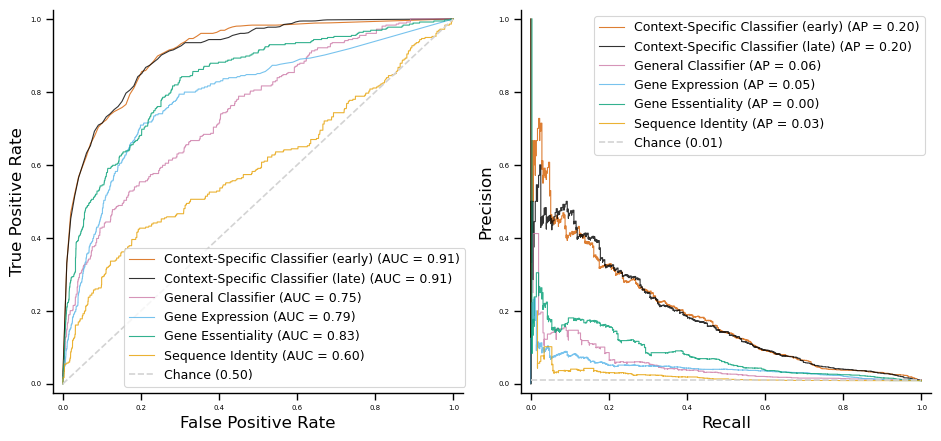

In [25]:
plot_model_performance(integrated_training_df_clean, data_1, target, model_I_early, model_I_late)#, figure_path_model1)

## Model II
#### Same paralog pairs, different cell lines

In [19]:
# Define group feature for cell lines
groups = integrated_training_df_clean['cell_line']

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
splits_II = list(sgkf.split(integrated_training_df_clean, target, groups))

for i, (train_index, test_index) in enumerate(splits_II):
    print(f'Fold {i+1}:')
    print(f"TRAIN: group={groups[train_index].unique()}")
    print(f"TEST: group={groups[test_index].unique()}")

Fold 1:
TRAIN: group=['PK1_PANCREAS' 'HS944T_SKIN' 'A549_LUNG' 'GI1_CENTRAL_NERVOUS_SYSTEM'
 'HS936T_SKIN' 'MELJUSO_SKIN' 'IPC298_SKIN' 'HSC5_SKIN']
TEST: group=['PATU8988S_PANCREAS' 'MEL202_UVEA']
Fold 2:
TRAIN: group=['PATU8988S_PANCREAS' 'PK1_PANCREAS' 'HS944T_SKIN'
 'GI1_CENTRAL_NERVOUS_SYSTEM' 'HS936T_SKIN' 'MELJUSO_SKIN' 'IPC298_SKIN'
 'MEL202_UVEA']
TEST: group=['A549_LUNG' 'HSC5_SKIN']
Fold 3:
TRAIN: group=['PATU8988S_PANCREAS' 'A549_LUNG' 'GI1_CENTRAL_NERVOUS_SYSTEM'
 'HS936T_SKIN' 'MELJUSO_SKIN' 'IPC298_SKIN' 'HSC5_SKIN' 'MEL202_UVEA']
TEST: group=['PK1_PANCREAS' 'HS944T_SKIN']
Fold 4:
TRAIN: group=['PATU8988S_PANCREAS' 'PK1_PANCREAS' 'HS944T_SKIN' 'A549_LUNG'
 'GI1_CENTRAL_NERVOUS_SYSTEM' 'IPC298_SKIN' 'HSC5_SKIN' 'MEL202_UVEA']
TEST: group=['HS936T_SKIN' 'MELJUSO_SKIN']
Fold 5:
TRAIN: group=['PATU8988S_PANCREAS' 'PK1_PANCREAS' 'HS944T_SKIN' 'A549_LUNG'
 'HS936T_SKIN' 'MELJUSO_SKIN' 'HSC5_SKIN' 'MEL202_UVEA']
TEST: group=['GI1_CENTRAL_NERVOUS_SYSTEM' 'IPC298_SKIN']


In [20]:
model_II_early = model_early_cross_validation(RF, data_1, target, splits_II)
model_II_late = model_late_cross_validation(RF, data_2, target, splits_II)

Fold 1: Train size = 32645, Test size = 8184
Fold 1/5 complete: ROC AUC = 0.8872, Elapsed time = 24.72 seconds
Fold 2: Train size = 32692, Test size = 8137
Fold 2/5 complete: ROC AUC = 0.8925, Elapsed time = 49.62 seconds
Fold 3: Train size = 32639, Test size = 8190
Fold 3/5 complete: ROC AUC = 0.8838, Elapsed time = 74.72 seconds
Fold 4: Train size = 32717, Test size = 8112
Fold 4/5 complete: ROC AUC = 0.9160, Elapsed time = 99.46 seconds
Fold 5: Train size = 32623, Test size = 8206
Fold 5/5 complete: ROC AUC = 0.9073, Elapsed time = 123.25 seconds
Cross-validation complete: Mean ROC AUC = 0.8969, Std ROC AUC = 0.0123
Fold 1: Train size = 32645, Test size = 8184
Fold 1/5 complete: ROC AUC = 0.8849, Elapsed time = 31.76 seconds
Fold 2: Train size = 32692, Test size = 8137
Fold 2/5 complete: ROC AUC = 0.8819, Elapsed time = 63.77 seconds
Fold 3: Train size = 32639, Test size = 8190
Fold 3/5 complete: ROC AUC = 0.8982, Elapsed time = 95.30 seconds
Fold 4: Train size = 32717, Test size = 

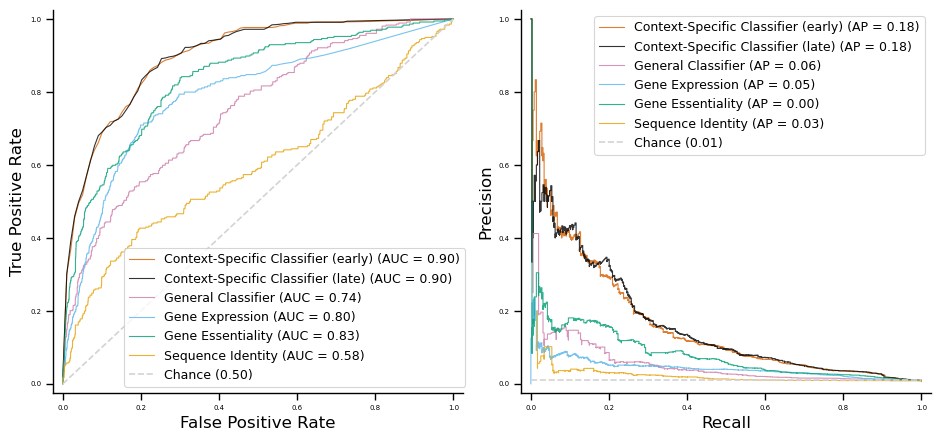

In [23]:
plot_model_performance(integrated_training_df_clean, data_1, target, model_II_early, model_II_late)#, figure_path_model2)

## Model III
#### Different paralog pairs, same cell lines

In [26]:
# Define group feature for gene pairs
gene_groups = integrated_training_df_clean['genepair']

sgkf2 = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
splits_III = list(sgkf.split(integrated_training_df_clean, target, gene_groups))

for i, (train_index, test_index) in enumerate(splits_III):
    print(f'Fold {i+1}:')
    print(f"TRAIN: group={groups[train_index].nunique()}")
    print(f"TEST: group={groups[test_index].nunique()}")
    print(f'# of overlapping pairs: {np.isin(groups[train_index].unique(), groups[test_index].unique()).sum()}') # True is 1, False is 0

Fold 1:
TRAIN: group=10
TEST: group=10
# of overlapping pairs: 10
Fold 2:
TRAIN: group=10
TEST: group=10
# of overlapping pairs: 10
Fold 3:
TRAIN: group=10
TEST: group=10
# of overlapping pairs: 10
Fold 4:
TRAIN: group=10
TEST: group=10
# of overlapping pairs: 10
Fold 5:
TRAIN: group=10
TEST: group=10
# of overlapping pairs: 10


In [27]:
model_III_early = model_early_cross_validation(RF, data_1, target, splits_III)
model_III_late = model_late_cross_validation(RF, data_2, target, splits_III)

Fold 1: Train size = 32663, Test size = 8166
Fold 1/5 complete: ROC AUC = 0.8704, Elapsed time = 25.78 seconds
Fold 2: Train size = 32663, Test size = 8166
Fold 2/5 complete: ROC AUC = 0.9004, Elapsed time = 52.18 seconds
Fold 3: Train size = 32692, Test size = 8137
Fold 3/5 complete: ROC AUC = 0.9177, Elapsed time = 76.24 seconds
Fold 4: Train size = 32649, Test size = 8180
Fold 4/5 complete: ROC AUC = 0.9199, Elapsed time = 98.06 seconds
Fold 5: Train size = 32649, Test size = 8180
Fold 5/5 complete: ROC AUC = 0.8992, Elapsed time = 120.27 seconds
Cross-validation complete: Mean ROC AUC = 0.9013, Std ROC AUC = 0.0177
Fold 1: Train size = 32663, Test size = 8166
Fold 1/5 complete: ROC AUC = 0.8668, Elapsed time = 30.37 seconds
Fold 2: Train size = 32663, Test size = 8166
Fold 2/5 complete: ROC AUC = 0.8968, Elapsed time = 60.69 seconds
Fold 3: Train size = 32692, Test size = 8137
Fold 3/5 complete: ROC AUC = 0.9097, Elapsed time = 91.17 seconds
Fold 4: Train size = 32649, Test size = 

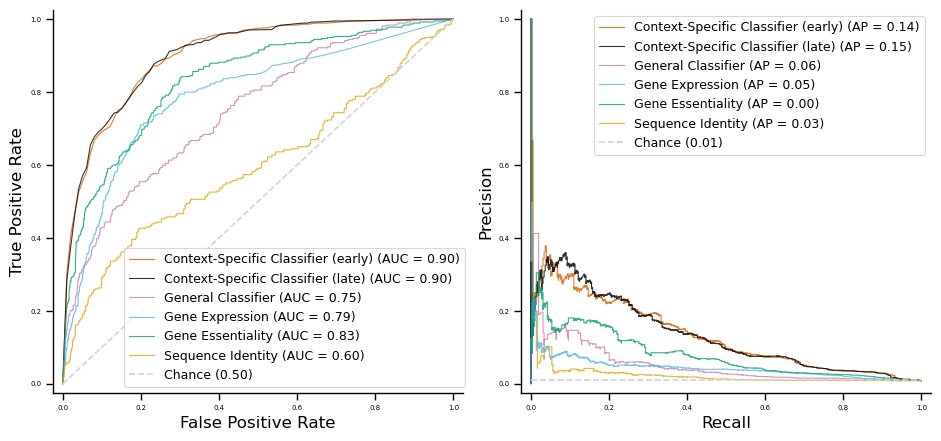

In [28]:
plot_model_performance(integrated_training_df_clean, data_1, target, model_III_early, model_III_late)#, figure_path_model3)

## Model IV
#### Different paralog pairs, different cell lines

In [29]:
def create_disjoint_splits(df, n_splits=5, num_test_cell_lines=2, test_gene_fraction=0.25, random_state=None):
    
    splits = []
    
    # Get the unique cell lines and gene pairs
    unique_cell_lines = df['DepMap_ID'].unique()
    unique_gene_pairs = df['genepair'].unique()

    # Set the random seed if provided
    if random_state is not None:
        np.random.seed(random_state)
    
    # Split cell lines into mutually exclusive groups
    np.random.shuffle(unique_cell_lines)
    cell_line_splits = np.array_split(unique_cell_lines, n_splits)
    
    # Split gene pairs into mutually exclusive groups
    np.random.shuffle(unique_gene_pairs)
    gene_pair_splits = np.array_split(unique_gene_pairs, n_splits)
    
    # Create the splits
    for fold in range(n_splits):
        # Select the current test cell lines and gene pairs
        test_cell_lines = cell_line_splits[fold]
        test_gene_pairs = gene_pair_splits[fold]
        
        # Use the remaining cell lines and gene pairs for the training set
        train_cell_lines = np.concatenate([cell_line_splits[i] for i in range(n_splits) if i != fold])
        train_gene_pairs = np.concatenate([gene_pair_splits[i] for i in range(n_splits) if i != fold])
        
        # Create the test set based on the selected cell lines and gene pairs
        test_index = df[(df['DepMap_ID'].isin(test_cell_lines)) & (df['genepair'].isin(test_gene_pairs))].index
        
        # Create the train set based on the remaining cell lines and gene pairs
        train_index = df[(df['DepMap_ID'].isin(train_cell_lines)) & (df['genepair'].isin(train_gene_pairs))].index
        
        # Append the split indices as a tuple (train_index, test_index)
        splits.append((train_index, test_index))

        print(f'# of unique pairs (train): {df["genepair"][train_index].nunique()}',
              f'# of unique pairs (test): {df["genepair"][test_index].nunique()}',
              f'# of overlapping pairs: {np.isin(df["genepair"][test_index].unique(), df["genepair"][train_index].unique()).sum()}' # True is 1, False is 0
              f'# of unique cells (train): {df["DepMap_ID"][train_index].unique()}',
              f'# of unique cells (test): {df["DepMap_ID"][test_index].unique()}')
    
    return splits

def repeated_custom_cv(df, n_splits=5, n_repeats=3, num_test_cell_lines=2, test_gene_fraction=0.25, random_state=None):

    all_splits = []
    
    for repeat in range(n_repeats):
        # Generate splits for each repetition with a different random seed (if provided)
        splits = create_disjoint_splits(df, n_splits=n_splits, num_test_cell_lines=num_test_cell_lines, 
                                        test_gene_fraction=test_gene_fraction, random_state=random_state + repeat if random_state else None)
        all_splits.extend(splits)
    
    return all_splits

In [30]:
splits_IV = repeated_custom_cv(df=integrated_training_df_clean, n_splits=5, n_repeats=20, random_state=42)

# of unique pairs (train): 3300 # of unique pairs (test): 825 # of overlapping pairs: 0# of unique cells (train): ['ACH-000022' 'ACH-000632' 'ACH-000681' 'ACH-000756' 'ACH-000801'
 'ACH-000881' 'ACH-000915' 'ACH-001554'] # of unique cells (test): ['ACH-000307' 'ACH-001524']
# of unique pairs (train): 3301 # of unique pairs (test): 825 # of overlapping pairs: 0# of unique cells (train): ['ACH-000307' 'ACH-000632' 'ACH-000681' 'ACH-000756' 'ACH-000881'
 'ACH-000915' 'ACH-001524' 'ACH-001554'] # of unique cells (test): ['ACH-000022' 'ACH-000801']
# of unique pairs (train): 3301 # of unique pairs (test): 823 # of overlapping pairs: 0# of unique cells (train): ['ACH-000022' 'ACH-000307' 'ACH-000681' 'ACH-000756' 'ACH-000801'
 'ACH-000881' 'ACH-001524' 'ACH-001554'] # of unique cells (test): ['ACH-000632' 'ACH-000915']
# of unique pairs (train): 3301 # of unique pairs (test): 825 # of overlapping pairs: 0# of unique cells (train): ['ACH-000022' 'ACH-000307' 'ACH-000632' 'ACH-000681' 'ACH-000

In [31]:
model_IV_early = model_early_cross_validation(RF, data_1, target, splits_IV)
model_IV_late = model_late_cross_validation(RF, data_2, target, splits_IV)

Fold 1: Train size = 26091, Test size = 1646
Fold 1/100 complete: ROC AUC = 0.9220, Elapsed time = 20.48 seconds
Fold 2: Train size = 26140, Test size = 1630
Fold 2/100 complete: ROC AUC = 0.9113, Elapsed time = 40.31 seconds
Fold 3: Train size = 26123, Test size = 1637
Fold 3/100 complete: ROC AUC = 0.9263, Elapsed time = 60.17 seconds
Fold 4: Train size = 26103, Test size = 1640
Fold 4/100 complete: ROC AUC = 0.8139, Elapsed time = 79.99 seconds
Fold 5: Train size = 26201, Test size = 1618
Fold 5/100 complete: ROC AUC = 0.9140, Elapsed time = 99.86 seconds
Fold 6: Train size = 26174, Test size = 1625
Fold 6/100 complete: ROC AUC = 0.8583, Elapsed time = 120.77 seconds
Fold 7: Train size = 26150, Test size = 1624
Fold 7/100 complete: ROC AUC = 0.9411, Elapsed time = 139.74 seconds
Fold 8: Train size = 26122, Test size = 1629
Fold 8/100 complete: ROC AUC = 0.8979, Elapsed time = 160.51 seconds
Fold 9: Train size = 26087, Test size = 1648
Fold 9/100 complete: ROC AUC = 0.8276, Elapsed t

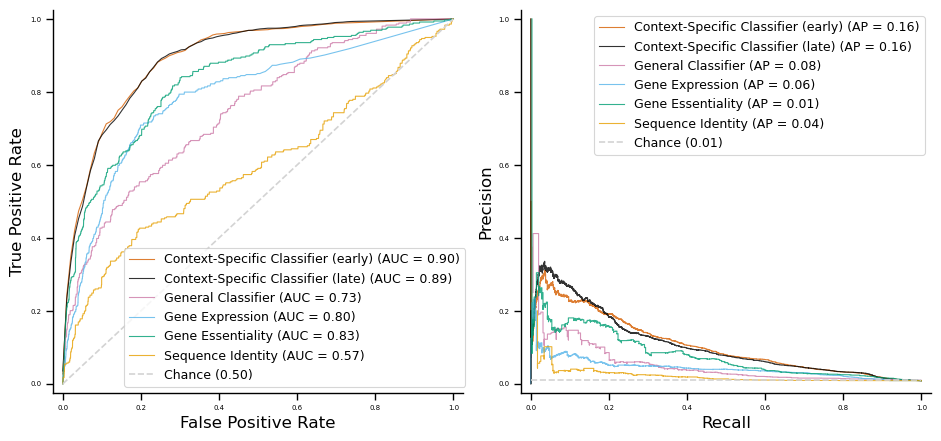

In [33]:
plot_model_performance(integrated_training_df_clean, data_1, target, model_IV_early, model_IV_late)

## Visualize the Class Balance

In [34]:
def class_balance(df, splits, k, title):
    percentages_train = []
    percentages_test = []
    train_sizes = []
    test_sizes = []
    # Loop through each split and calculate the percentage of True values
    for i in range(k):
    # Get the subset of the DataFrame based on the split indices
        subset1 = df.iloc[splits[i][0]]
        subset2 = df.iloc[splits[i][1]]
        # Calculate the percentage of True values in the subset
        percentage_true_train = (subset1['SL_08'].sum() / len(subset1['SL_08'])) * 100
        percentage_true_test = (subset2['SL_08'].sum() / len(subset2['SL_08'])) * 100
        # Append the percentage to the list
        percentages_train.append(percentage_true_train)
        percentages_test.append(percentage_true_test)
        train_sizes.append(len(subset1))
        test_sizes.append(len(subset2))
    width = 0.35
    x = np.arange(k)
    #define colors
    train_color = '#0072B2'
    test_color = '#E69F00'
    # Create the figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    # Plot 1: Grouped bar chart for percentages
    ax1.bar(x - width/2, percentages_train, width, label='Train', color=train_color)
    ax1.bar(x + width/2, percentages_test, width, label='Test', color=test_color)
    ax1.set_xlabel('Split Number')
    ax1.set_ylabel('Percentage of True Values')
    ax1.set_title('Percentage of True Values in Train and Test Splits:'+ title)
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'Split {i}' for i in range(k)])
    ax1.bar_label(ax1.containers[0], label_type='edge', fmt='%.2f')
    ax1.bar_label(ax1.containers[1], label_type='edge', fmt='%.2f')
    ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    # Plot 2: Grouped bar chart for number of rows
    ax2.bar(x - width/2, train_sizes, width, label='Train Size', color=train_color)
    ax2.bar(x + width/2, test_sizes, width, label='Test Size', color=test_color)
    ax2.set_xlabel('Split Number')
    ax2.set_ylabel('Number of Rows')
    ax2.set_title('Number of Rows in Train and Test Subsets:' + title)
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'Split {i}' for i in range(k)])
    ax2.bar_label(ax2.containers[0], label_type='edge')
    ax2.bar_label(ax2.containers[1], label_type='edge')
    #ax2.legend()
    ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    # Adjust layout
    plt.tight_layout()
    # Show the plots
    plt.show()

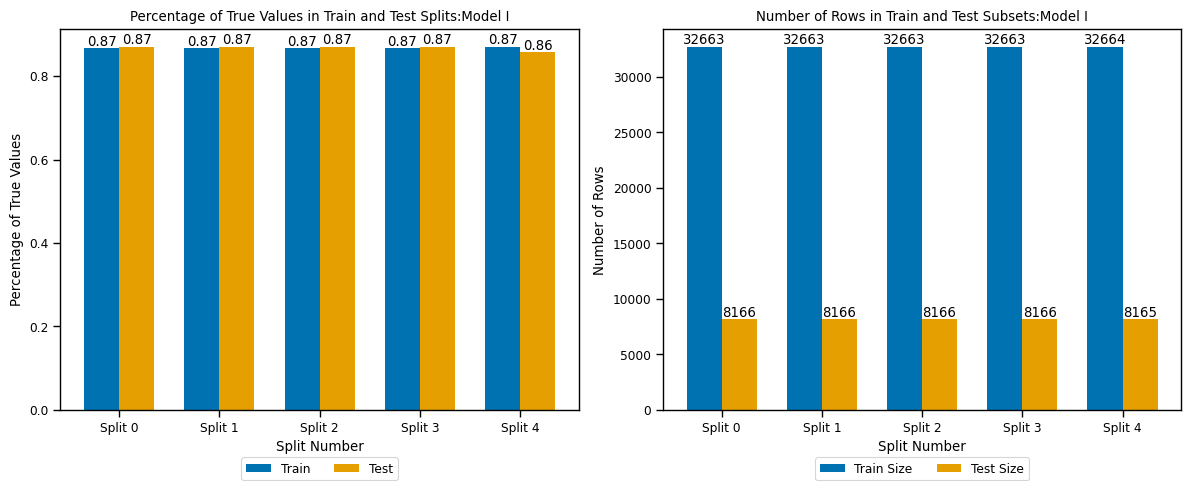

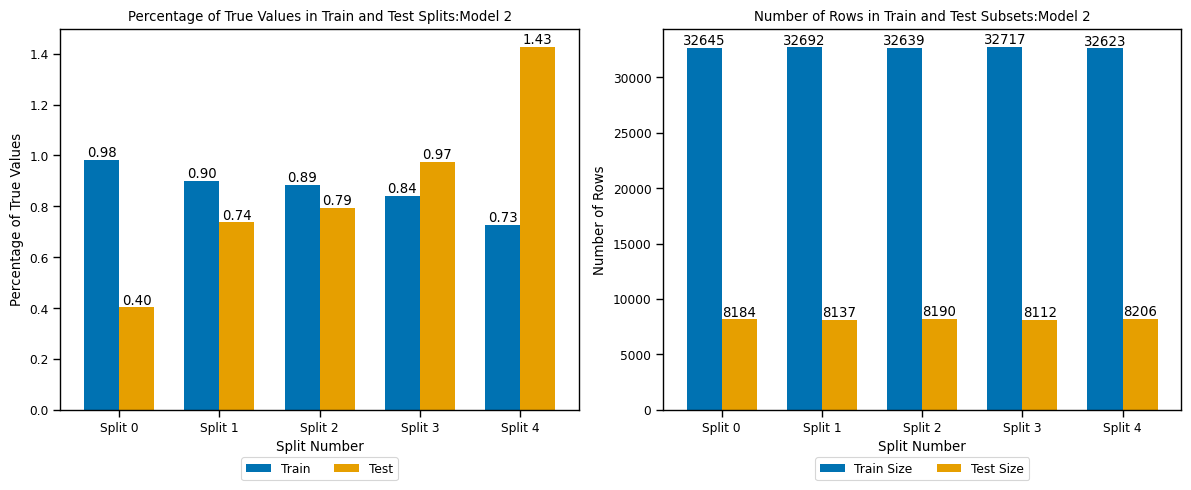

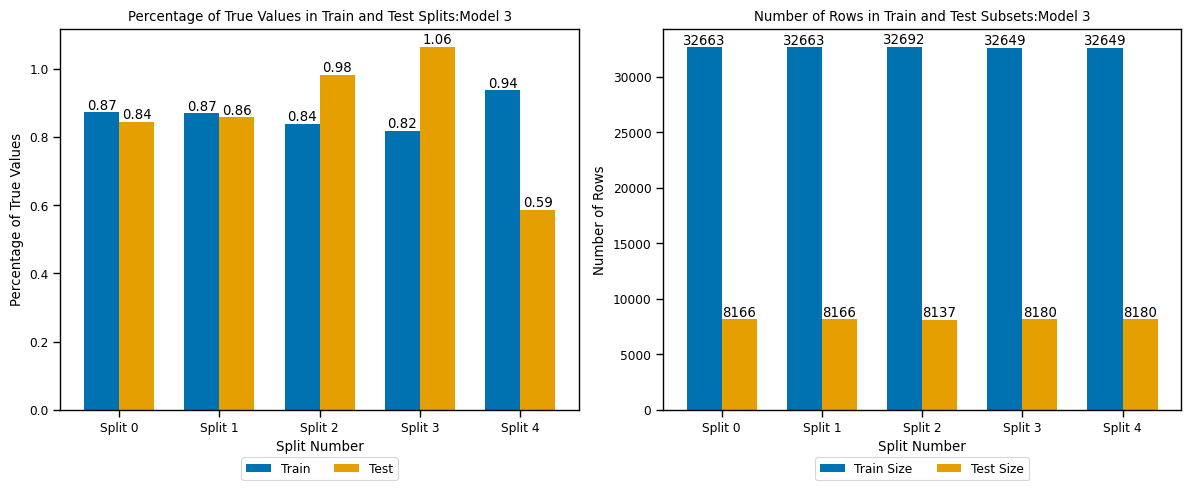

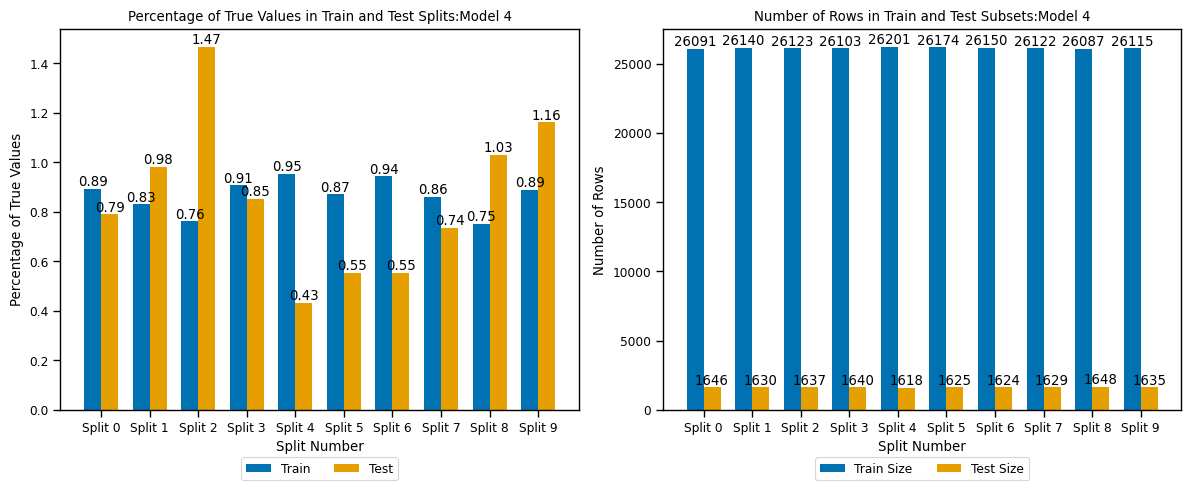

In [35]:
class_balance(integrated_training_df_clean, splits_I, 5, "Model I")
class_balance(integrated_training_df_clean, splits_II, 5, "Model 2")
class_balance(integrated_training_df_clean, splits_III, 5, "Model 3")
class_balance(integrated_training_df_clean, splits_IV, 10, "Model 4")